# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions (different archetypes from the paper)
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.utils as utils
import src.plot_multi_analysis as pma
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
from copy import deepcopy
import random

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [4]:
class EvolutionnarySearch:
    def __init__(
        self,
        simulation,
        p_best_parents=2,
        pop_size=20,
        n_gen=30,
        mutation_rate=0.2,
        initial_mutation_spread=0.1,
        econ_weight=1,
        ecol_weight=1,
    ):
        """
        Create an EvolutionnarySearch object to run a parameter exploration around policies.

        Args:
            simulation: configurated simulation wich will serve as evaluation protocol.
            p_best: proportion of best individus to select as parent for next generation : total_ind // p_best.
            pop_size: number of generated variants per generation.
            n_gen: number of generation.
            mutation_rate: the proportion of children that will differ from parents.
            initial_mutation_spread: how much childrens will differ from parents (decreasing along generation).
            econ_weight: how economic impact is considerated in adjusted_score consideration.
            ecol_weight: how ecologic impact is considerated in adjusted_score consideration.

        Returns:
            EvolutionnarySearch object ready to run
        """
        self.simulation = simulation
        self.p_best_parents = p_best_parents
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.mutation_rate = mutation_rate
        self.initial_mutation_spread = initial_mutation_spread
        self.econ_weight = econ_weight
        self.ecol_weight = ecol_weight
        self.execution_results = []

    def generate_individuals(self):
        """
        Generate required params for both policies.

        Returns:
            dict: Dictionary containing parameters for both incentive and quota policies \n
            {
                "incentive_params":{...},\n
                "quota_params": {...}
            }
        """
        return {
            "incentive_params": {
                # crisis params
                    # fines params
                    "crisis_avg_incomes_fine_factor": random.uniform(0, 10),
                    "crisis_actors_priority_fine_factor": random.uniform(-5, 5),
                    "crisis_stress_fine_factor": random.uniform(0, 10),
                    # subsidies params
                    "crisis_avg_incomes_subsidy_factor": random.uniform(-10, 50),
                    "crisis_actors_priority_subsidy_factor": random.uniform(-10, 10),
                    "crisis_stress_subsidy_factor": random.uniform(0, 10),
                # normal params
                    # fines params
                    "avg_incomes_fine_factor": random.uniform(0, 10),
                    "actors_priority_fine_factor": random.uniform(-5, 5),
                    "stress_fine_factor": random.uniform(0, 10),
                    # subsidies params
                    "avg_incomes_subsidy_factor": random.uniform(-10, 50),
                    "actors_priority_subsidy_factor": random.uniform(-10, 10),
                    "stress_subsidy_factor": random.uniform(0, 10),
            },
            "quota_params": {
                "avg_pump_factor": random.uniform(-5, 5),
                "actor_priority_factor": random.uniform(-5, 5),
                "crisis_level_factor": random.uniform(-10, 10),
            },
        }

    def mutate(self, ind, gen):
        """
        Mutate parameters of an individual. Operates on both 'quota_params' and 'incentive_params'.

        Args:
            ind: individu to mutate.
            gen: generation number, wich will impact the strengh of mutation.

        Returns:
            dict: mutated individual
        """
        ind = deepcopy(ind)

        current_mutation_spread = self.initial_mutation_spread * ((self.n_gen - gen) / self.n_gen)
        print(f"current_mutation_spread : {current_mutation_spread}")
        
        for policy_key in ["quota_params", "incentive_params"]:
            for param_key in ind[policy_key]:
                if random.random() < self.mutation_rate:
                    ind[policy_key][param_key] += np.random.normal(0, current_mutation_spread)

        return ind

    def select(self, population, scores):
        """
        Select half of the best individuals from the population based on their scores.

        Returns:
            tab of inidividus.
        """

        return [ind for _, ind in sorted(zip(scores, population), key=lambda x: -x[0])][
            : self.pop_size // self.p_best_parents
        ]

    def make_quota_function(self, params):
        """
        Based on given parameters it generate a quota policy.

        Returns:
            func: Quota policy.
        """

        def custom_quota(self, crisis_level, actors_priority, avg_pump, DOE, DCR):
            quota = (
                params["avg_pump_factor"] * avg_pump
                + params["actor_priority_factor"] * actors_priority
                + params["crisis_level_factor"] * crisis_level
            )
            # Forcer des quotas réalistes (>= 0)
            return np.clip(quota, 0, avg_pump)

        return custom_quota

    def make_incentive_function(self, params):
        """
        Based on given parameters it generate an incentive policy.

        Returns:
            func: Incentive policy.
        """

        def custom_incentive(
            self,
            actions: np.ndarray,
            actors_priority: np.ndarray,
            avg_incomes: np.ndarray,
            water_pump: np.ndarray,
            avg_pump: np.ndarray,
            is_crisis: np.ndarray,
            water_flows: np.ndarray,
            quota: np.ndarray,
            DOE=15,
            DCR=10,
        ):
            fine = np.zeros(self.nb_actors)
            stress = is_crisis[-1]  # Current crisis level

            # If average income is negative, replace it with 0
            avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)

            for i in range(self.nb_actors):

                # Crisis case
                if (stress >= 0):
                    # Policy for actors who exceed their quota
                    if (water_pump[i] > quota[i]):
                        fine[i] = params["crisis_avg_incomes_fine_factor"] 
                        +(params["crisis_actors_priority_fine_factor"] * (1 + actors_priority[i]))
                        +(params["crisis_stress_fine_factor"] * (1 + stress))

                    # Policy for actors who respect their quota
                    elif (water_pump[i] <= quota[i]):
                        fine[i] = -(
                            params["crisis_avg_incomes_subsidy_factor"] * avg_incomes[i]
                            + (
                                params["crisis_actors_priority_subsidy_factor"]
                                * (1 + actors_priority[i])
                            )
                            + (params["crisis_stress_subsidy_factor"] * (1 + stress))
                        )
                # Non-crisis case
                else:
                    # Policy for actors who exceed their quota
                    if (water_pump[i] > quota[i]):
                        fine[i] = params["avg_incomes_fine_factor"] 
                        +(params["actors_priority_fine_factor"] * (1 + actors_priority[i]))
                        +(params["stress_fine_factor"] * (1 + stress))

                    # Policy for actors who respect their quota                    
                    elif (water_pump[i] <= quota[i]):
                        fine[i] = -(
                            params["avg_incomes_subsidy_factor"] * avg_incomes[i]
                            + (
                                params["actors_priority_subsidy_factor"]
                                * (1 + actors_priority[i])
                            )
                            + (params["stress_subsidy_factor"] * (1 + stress))
                        )

            return fine

        return custom_incentive

    def score_fn(self, incentive_policy, quota_policy, simulation):
        """
        Run a simulation based on give policy and compute scores.

        Returns:
            Tuple:  - adjusted_score = economic_impact - ecological_impact.\n
                    - ecological_impact = ecological impact of the simulation.\n
                    - economic_impact = economic impact of the simulation.
        """
        # Lier les politiques
        simulation.incentive_policy = MethodType(incentive_policy, simulation)
        simulation.compute_actor_quota = MethodType(quota_policy, simulation)

        simulation.run_simulation()
        ecological_impact, economic_impact = simulation.get_final_scores_scaled()

        adjusted_score = economic_impact - ecological_impact

        return adjusted_score, ecological_impact, economic_impact

    def get_best_result(self):
        adjusted_score = np.array(
            [r["adjusted_score"] for r in self.execution_results]
        )

        # Meilleur score
        best_idx = np.argmax(adjusted_score)
        return self.execution_results[best_idx]

    def run_search(self):
        """
        Run all simulations based on given search parameters.

        Returns:
            tab:
                - **dict**
                    - generation = generation number.
                    - quota_params = **dict** -> quota params.
                    - incentive_params = **dict** -> incentive params.
                    - ecological_impact = economic impact of the simulation.
                    - economic_impact = economic impact of the simulation.
                    - adjusted_score = economic impact of the simulation.
        """
        population = [self.generate_individuals() for _ in range(self.pop_size)]

        for gen in range(self.n_gen + 1):
            scored = [-999]
            # Pour tous les individus d'une génération, on évalue le score
            it = 0
            for ind in population:
                it = it + 1
                print(f"iteration gen {gen} : {it}")
                quota_policy = self.make_quota_function(ind["quota_params"])
                incentive_policy = self.make_incentive_function(ind["incentive_params"])
                adjusted_score, ecological_impact, economic_impact = self.score_fn(
                    incentive_policy, quota_policy, self.simulation
                )
                self.execution_results.append(
                    {
                        "generation": gen,
                        "quota_params": ind["quota_params"],
                        "incentive_params": ind["incentive_params"],
                        "ecological_impact": ecological_impact,
                        "economic_impact": economic_impact,
                        "adjusted_score": adjusted_score,
                        "simulation": self.simulation if adjusted_score >= max(scored) else None,
                    }
                )
                scored.append(adjusted_score)

            best_score = max(scored)
            print(f"Génération {gen}, meilleur score : {best_score:.4f}")

            # Reproduction, on prend la moitié des meilleurs et on les mutent
            selected = self.select(population, scored)
            children = []
            while len(children) < self.pop_size:
                parent = random.choice(selected)
                child = self.mutate(parent, gen)
                children.append(child)

            population = children

        # On retourne le réssultat d'éxecution au complet
        return self.execution_results

In [5]:
search = EvolutionnarySearch(
    simulation=None,
    p_best_parents=4,
    pop_size=15,
    n_gen=7,
    mutation_rate=0.7,
    initial_mutation_spread=0.85,
)

evol_results = {'generation': 1, 'quota_params': {'avg_pump_factor': 1.4460362452777173, 'actor_priority_factor': -2.263978180577131, 'crisis_level_factor': -2.3296922636011743}, 'incentive_params': {'crisis_avg_incomes_fine_factor': 2.3252166559062277, 'crisis_actors_priority_fine_factor': -3.0094875807846284, 'crisis_stress_fine_factor': 8.537241328680608, 'crisis_avg_incomes_subsidy_factor': 8.998958767019081, 'crisis_actors_priority_subsidy_factor': -6.090949303358589, 'crisis_stress_subsidy_factor': 6.010102597614287, 'avg_incomes_fine_factor': -0.30039701975389965, 'actors_priority_fine_factor': 2.934081211841047, 'stress_fine_factor': 6.090539523136615, 'avg_incomes_subsidy_factor': 9.508965798361235, 'actors_priority_subsidy_factor': 2.4996586898803628, 'stress_subsidy_factor': 4.100263582096292}, 'ecological_impact': np.float64(0.5415322580645161), 'economic_impact': np.float64(0.8178299480206599), 'adjusted_score': np.float64(0.2762976899561438), 'simulation': None}

custom_incentive_policy = search.make_incentive_function(evol_results['incentive_params'])
custom_quota_policy = search.make_quota_function(evol_results['quota_params'])

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [6]:
if True:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=10,
        custom_incentive_policy=custom_incentive_policy,
        custom_quota=custom_quota_policy)


Starting simulations across all scenarios...
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.0, Eco Impact: 2.646, Econ Impact: -5.017, Raw Eco Impact: 1280.0, Cooperation %: 72.6%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.25, Eco Impact: 2.634, Econ Impact: -5.150, Raw Eco Impact: 1259.0, Cooperation %: 72.5%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.5, Eco Impact: 2.644, Econ Impact: -4.877, Raw Eco Impact: 1278.0, Cooperation %: 73.1%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.25, Uncertainty: 0.0, Eco Impact: 2.650, Econ Impact: -5.184, Raw Eco Impact: 1288.0, Cooperation %: 72.1%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.25, Uncertainty: 0.25, Eco Impact: 2.648, Econ Impact: -5.195, Raw Eco Impact: 1284.0, Cooperation %: 71.9%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.25, Uncertainty: 0.5, Eco Impact: 2.638, Econ Impact: -5.074, Raw Eco Impact: 1266.0, Cooperation %: 72.5%
Sc


## Multi-Scenario Analysis


Save the results if needed.

In [7]:
# save results_df to csv
results_df.to_csv('results_df.csv', index=False)

# load results_df from csv
results_df = pd.read_csv('results_df.csv')


### Ecological vs. economic impact.

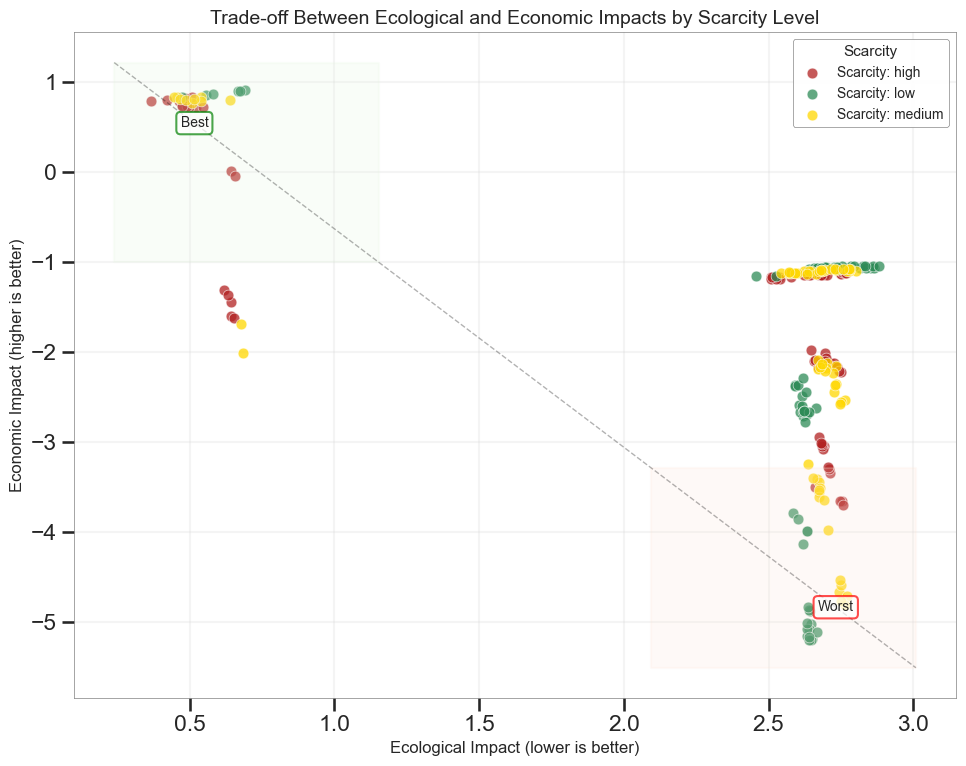

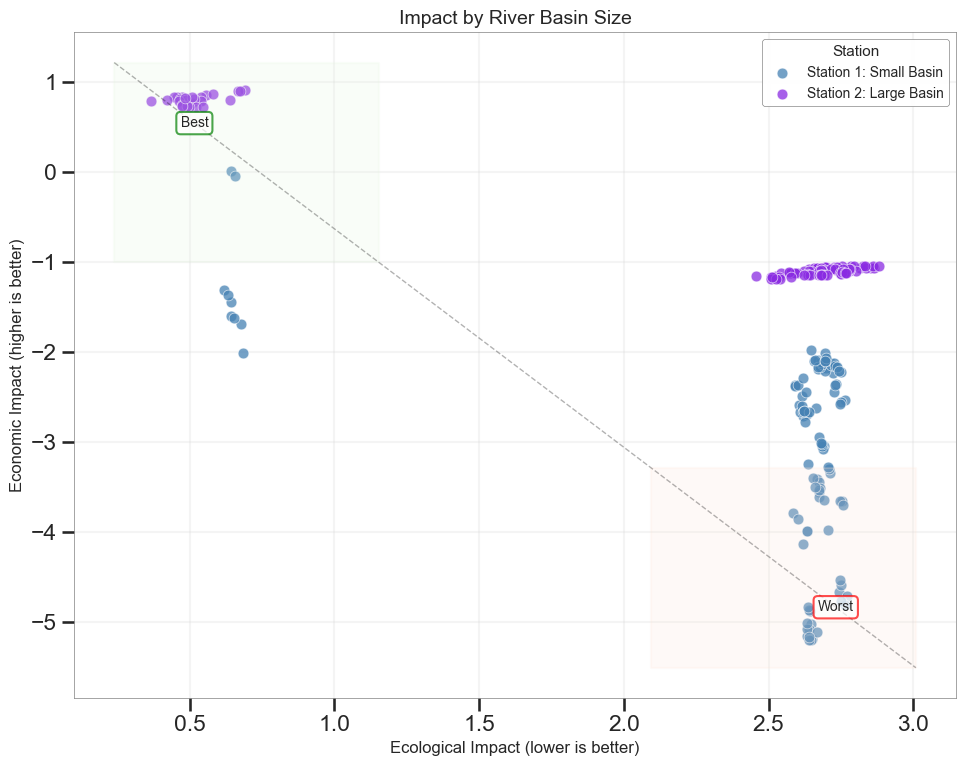

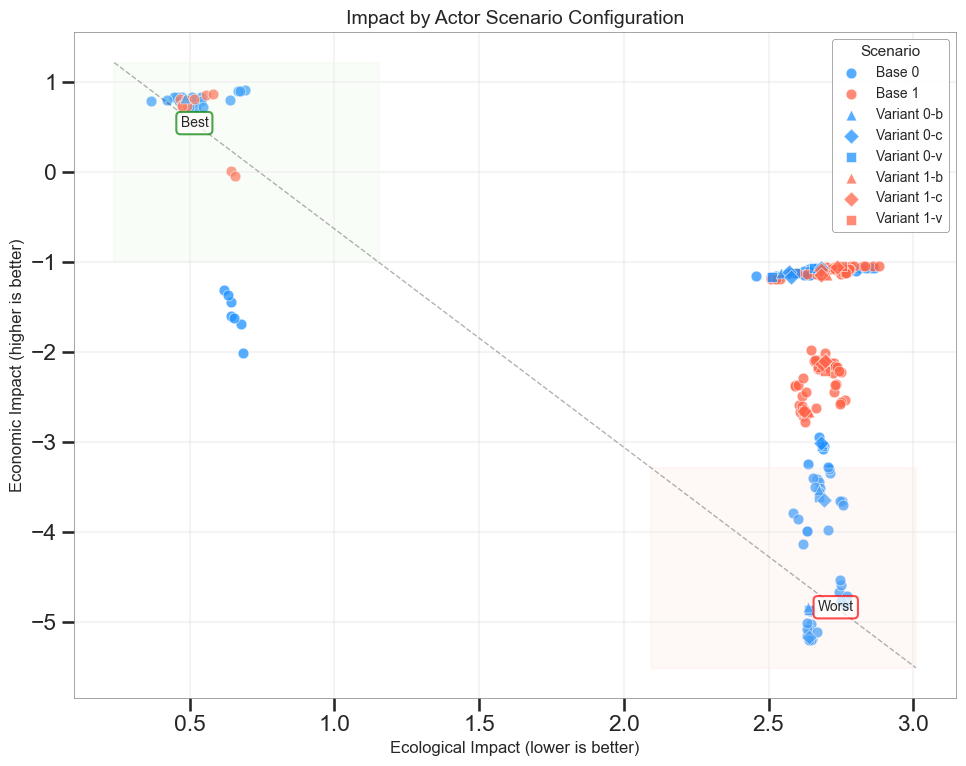

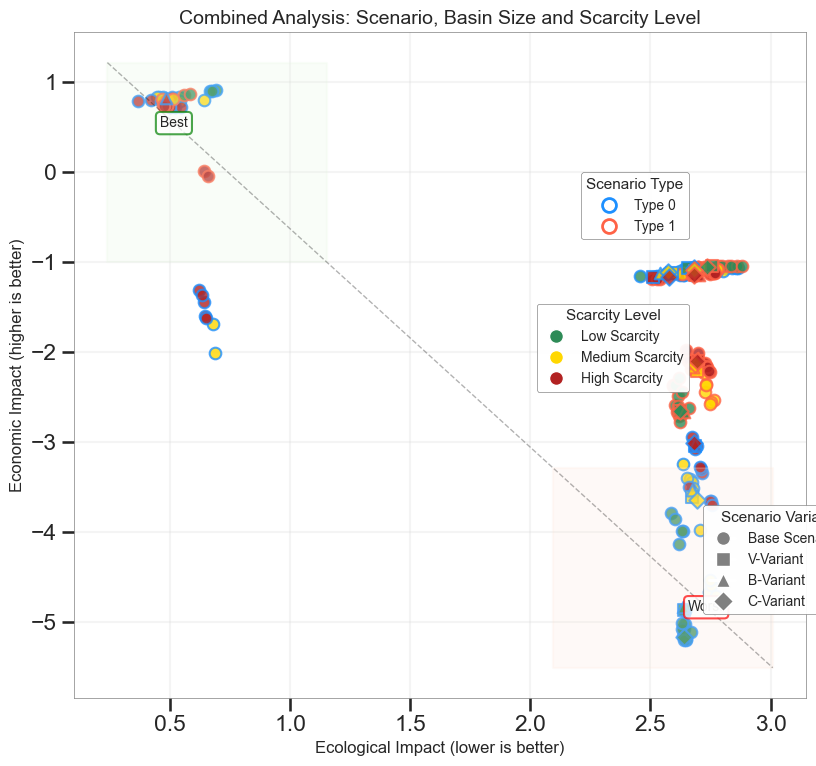

In [15]:
pma.analyze_scenario_impacts(results_df)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

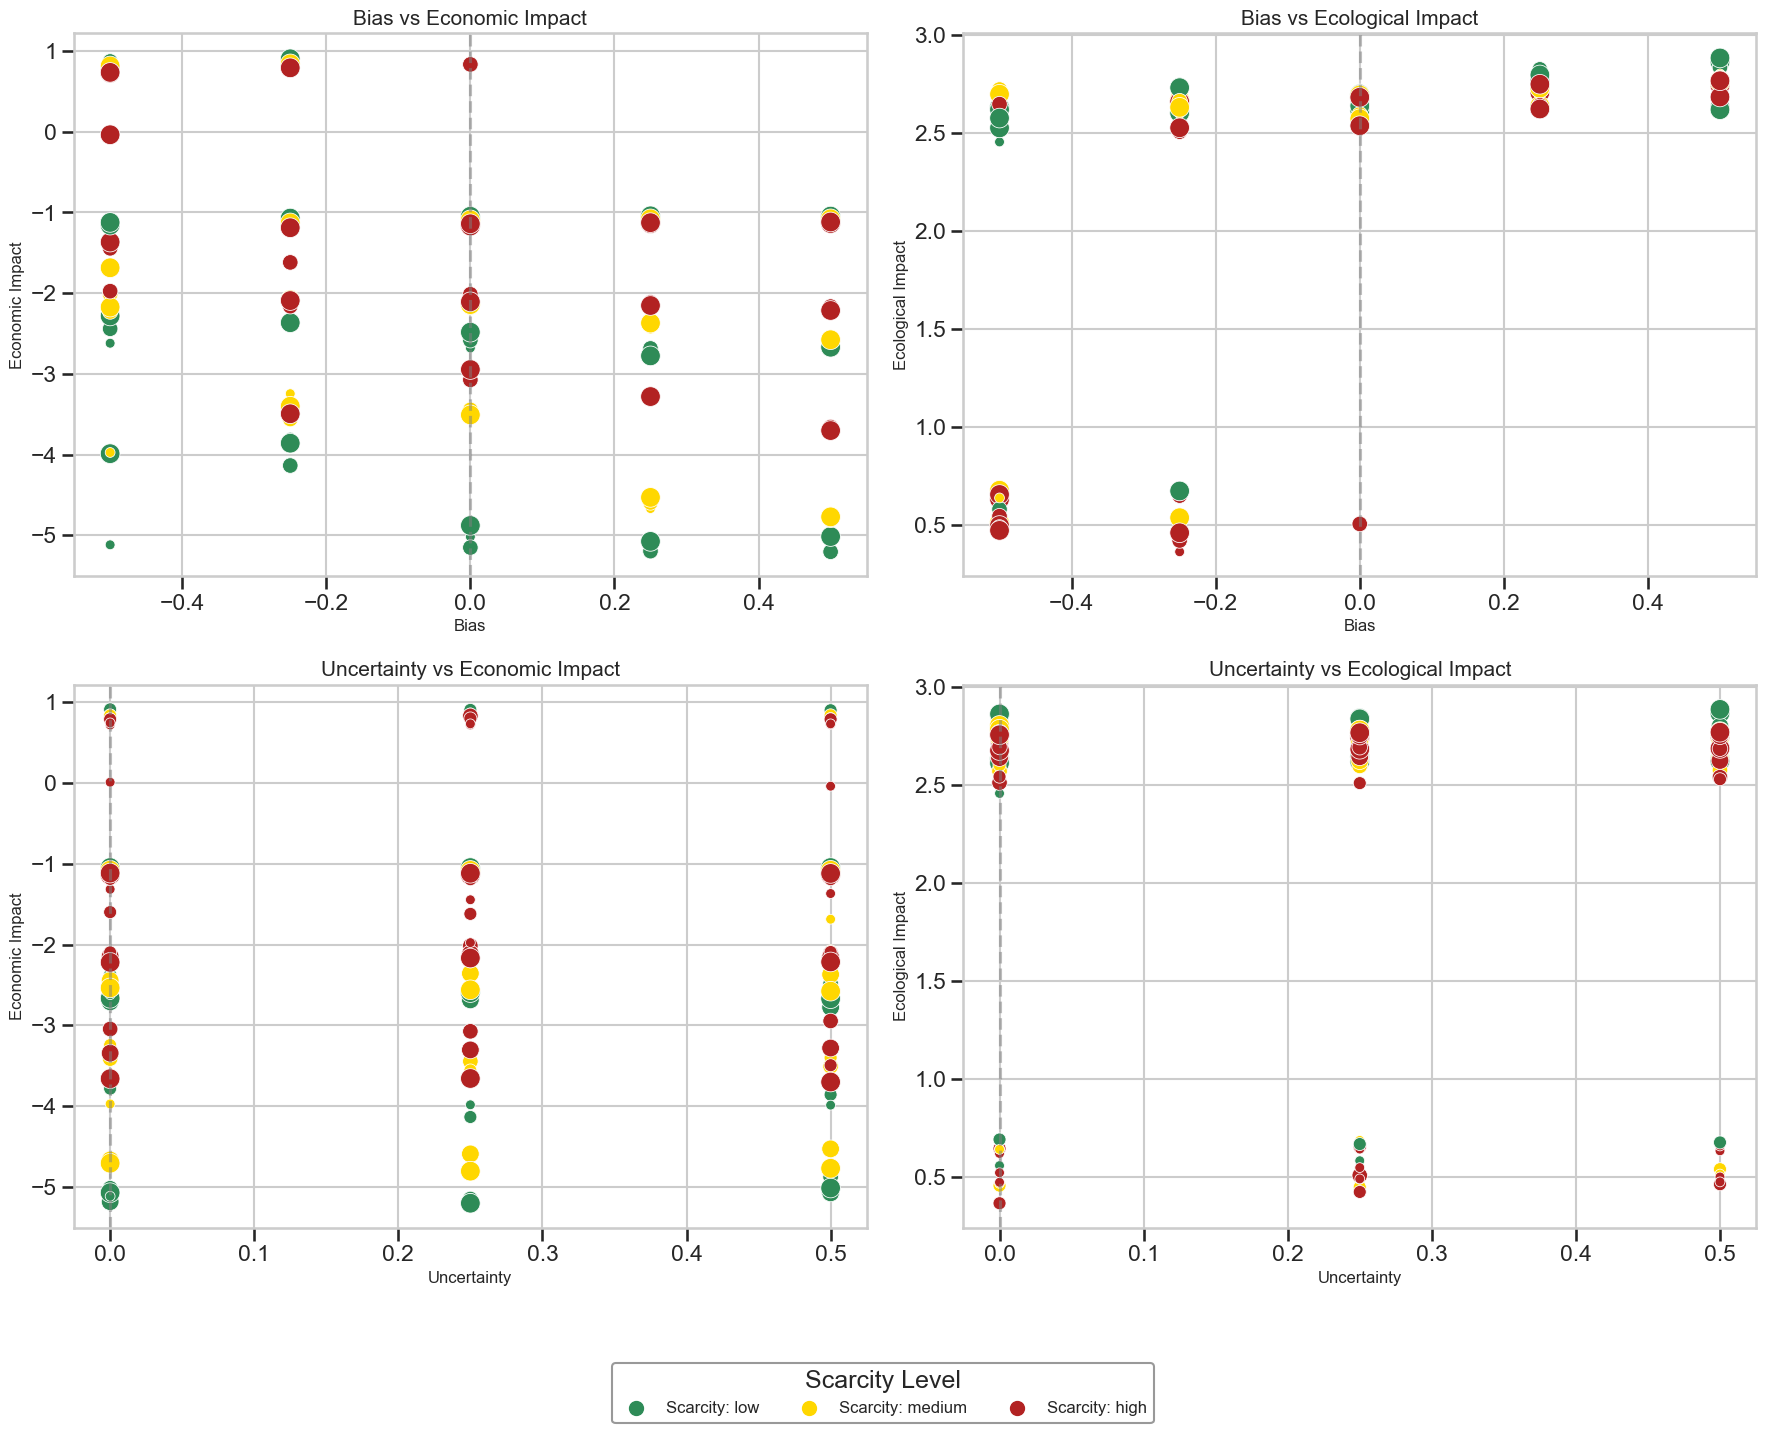

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:318: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:318: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


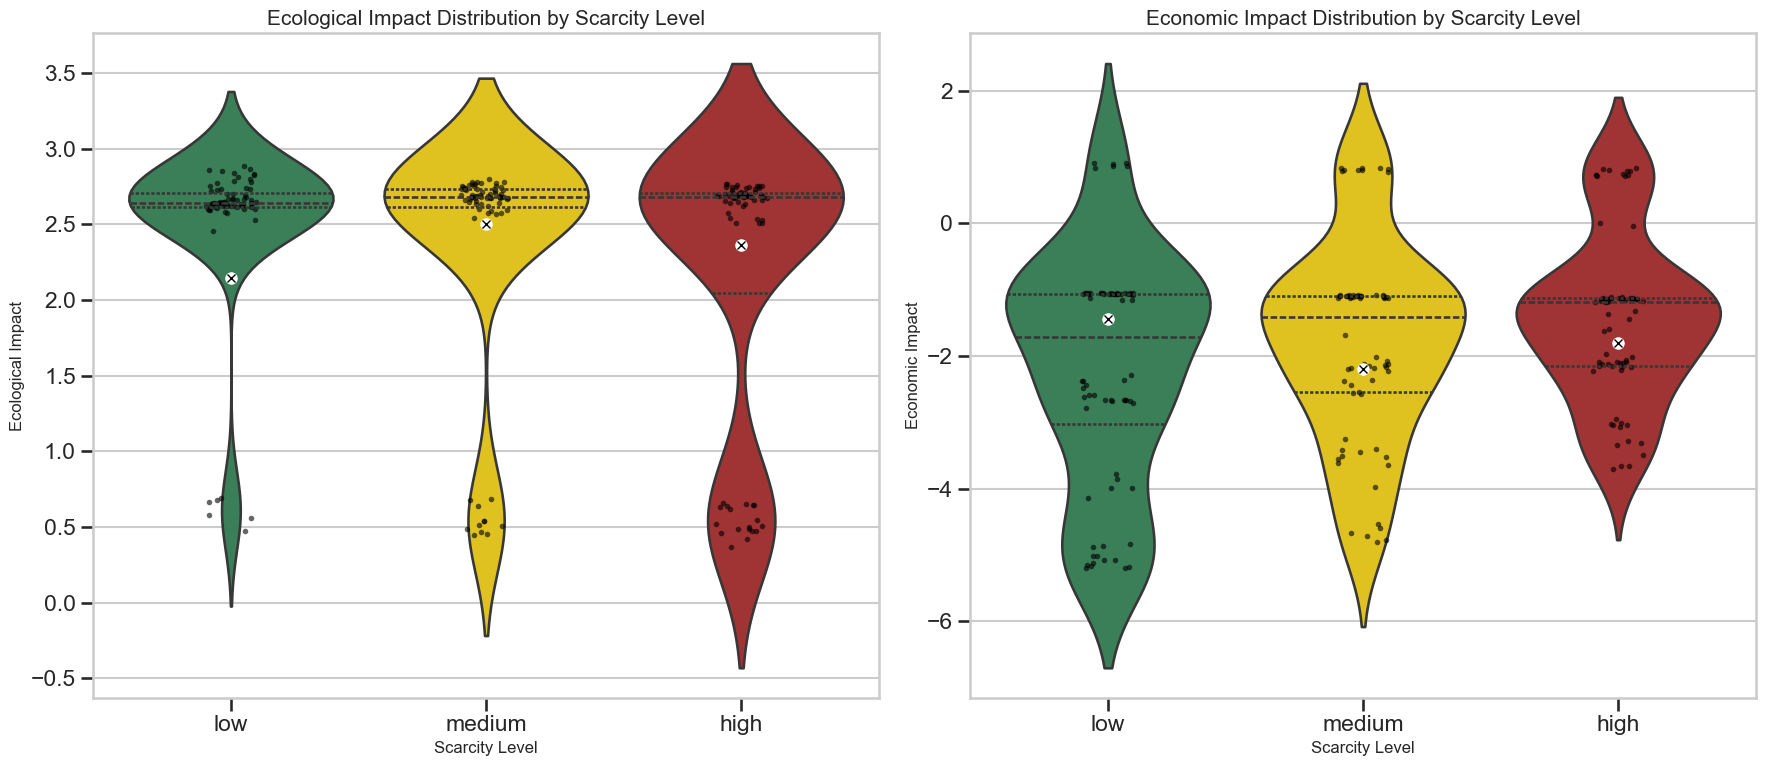

In [9]:
pma.analyze_forecast_effects(results_df)

## Correlation Analysis


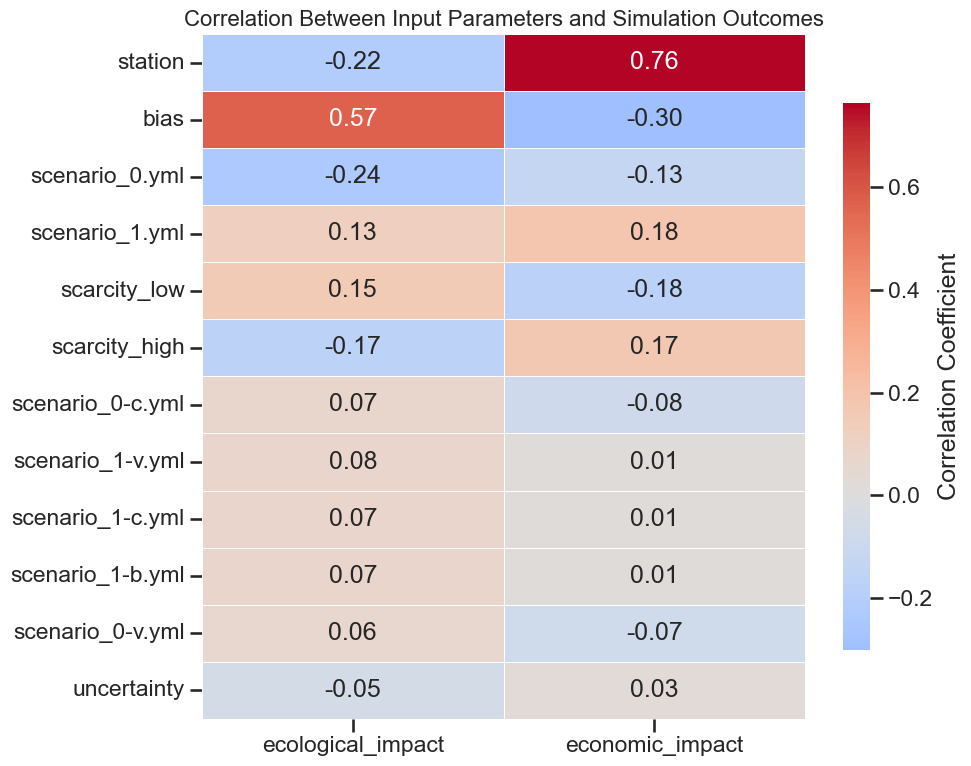


Top impacts on ecological_impact:

Top 5 positive correlations:
  bias: 0.568
  scarcity_low: 0.148
  scenario_1.yml: 0.127
  scenario_1-v.yml: 0.076
  scenario_1-c.yml: 0.074

Top 5 negative correlations:
  scenario_0-b.yml: -0.012
  uncertainty: -0.053
  scarcity_high: -0.172
  station: -0.216
  scenario_0.yml: -0.240

Top impacts on economic_impact:

Top 5 positive correlations:
  station: 0.764
  scenario_1.yml: 0.178
  scarcity_high: 0.172
  uncertainty: 0.029
  scenario_1-c.yml: 0.014

Top 5 negative correlations:
  scenario_0-v.yml: -0.072
  scenario_0-c.yml: -0.078
  scenario_0.yml: -0.130
  scarcity_low: -0.176
  bias: -0.301


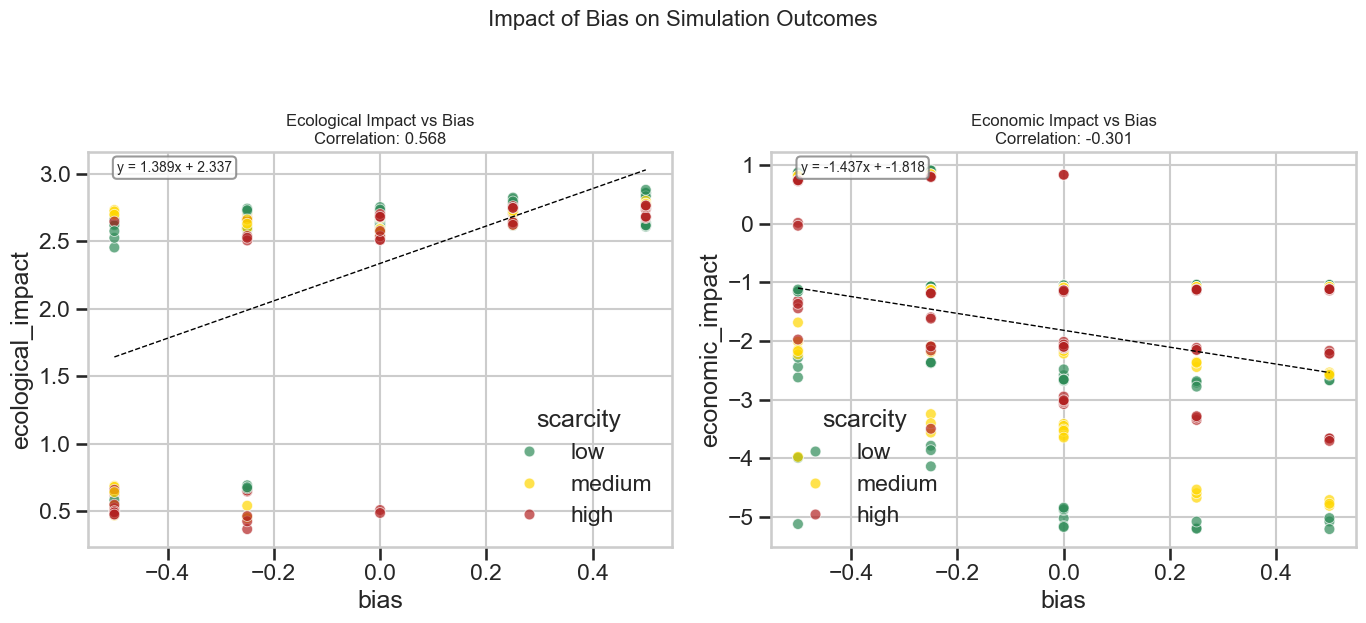

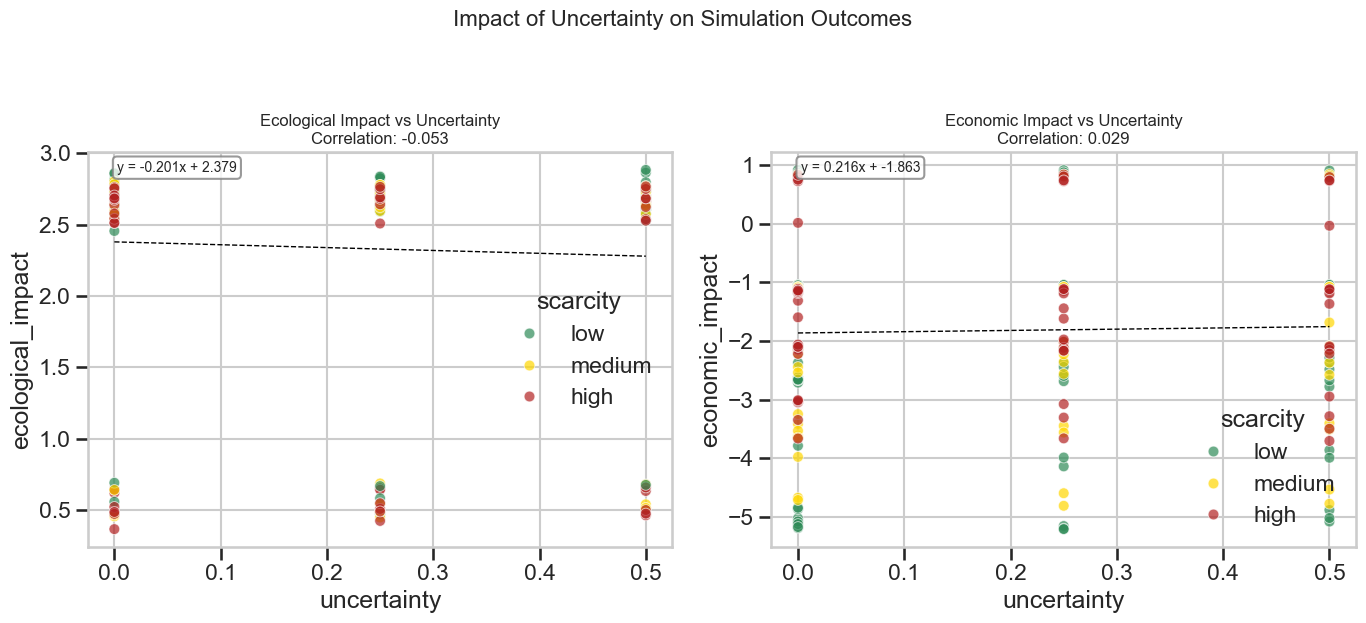

<Figure size 1200x1000 with 0 Axes>

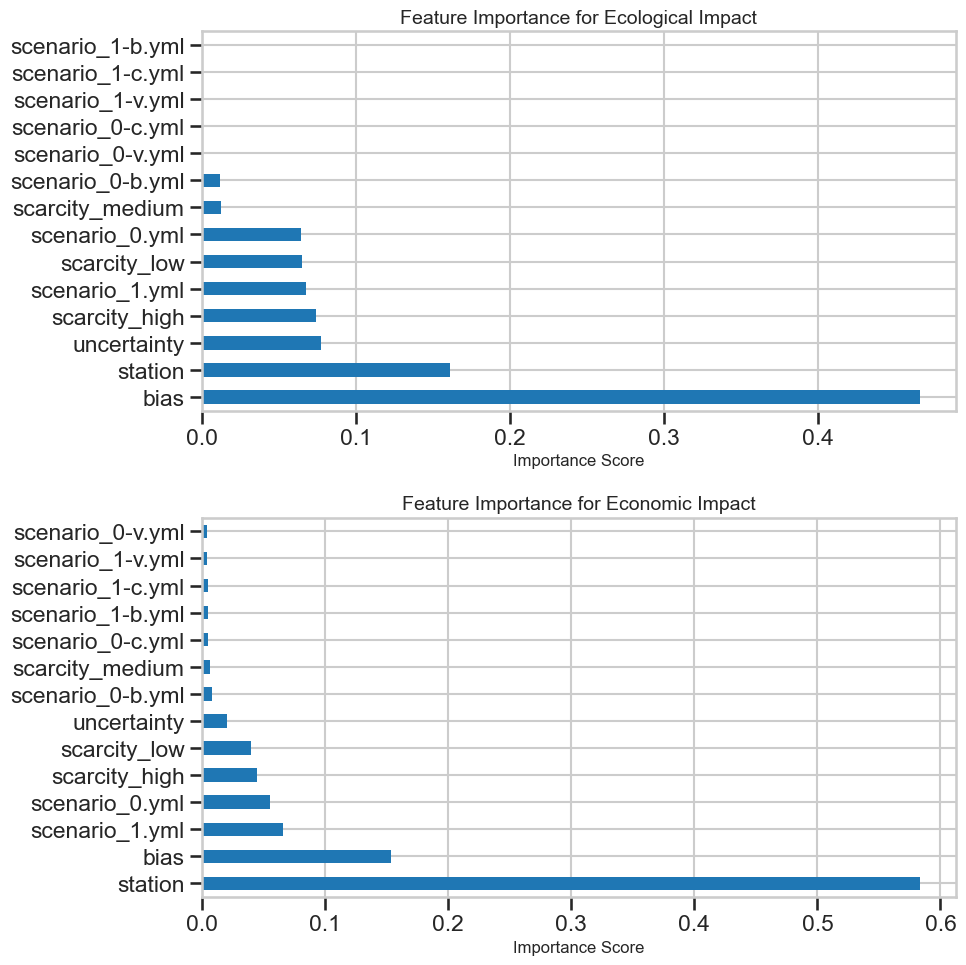

In [10]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:920: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


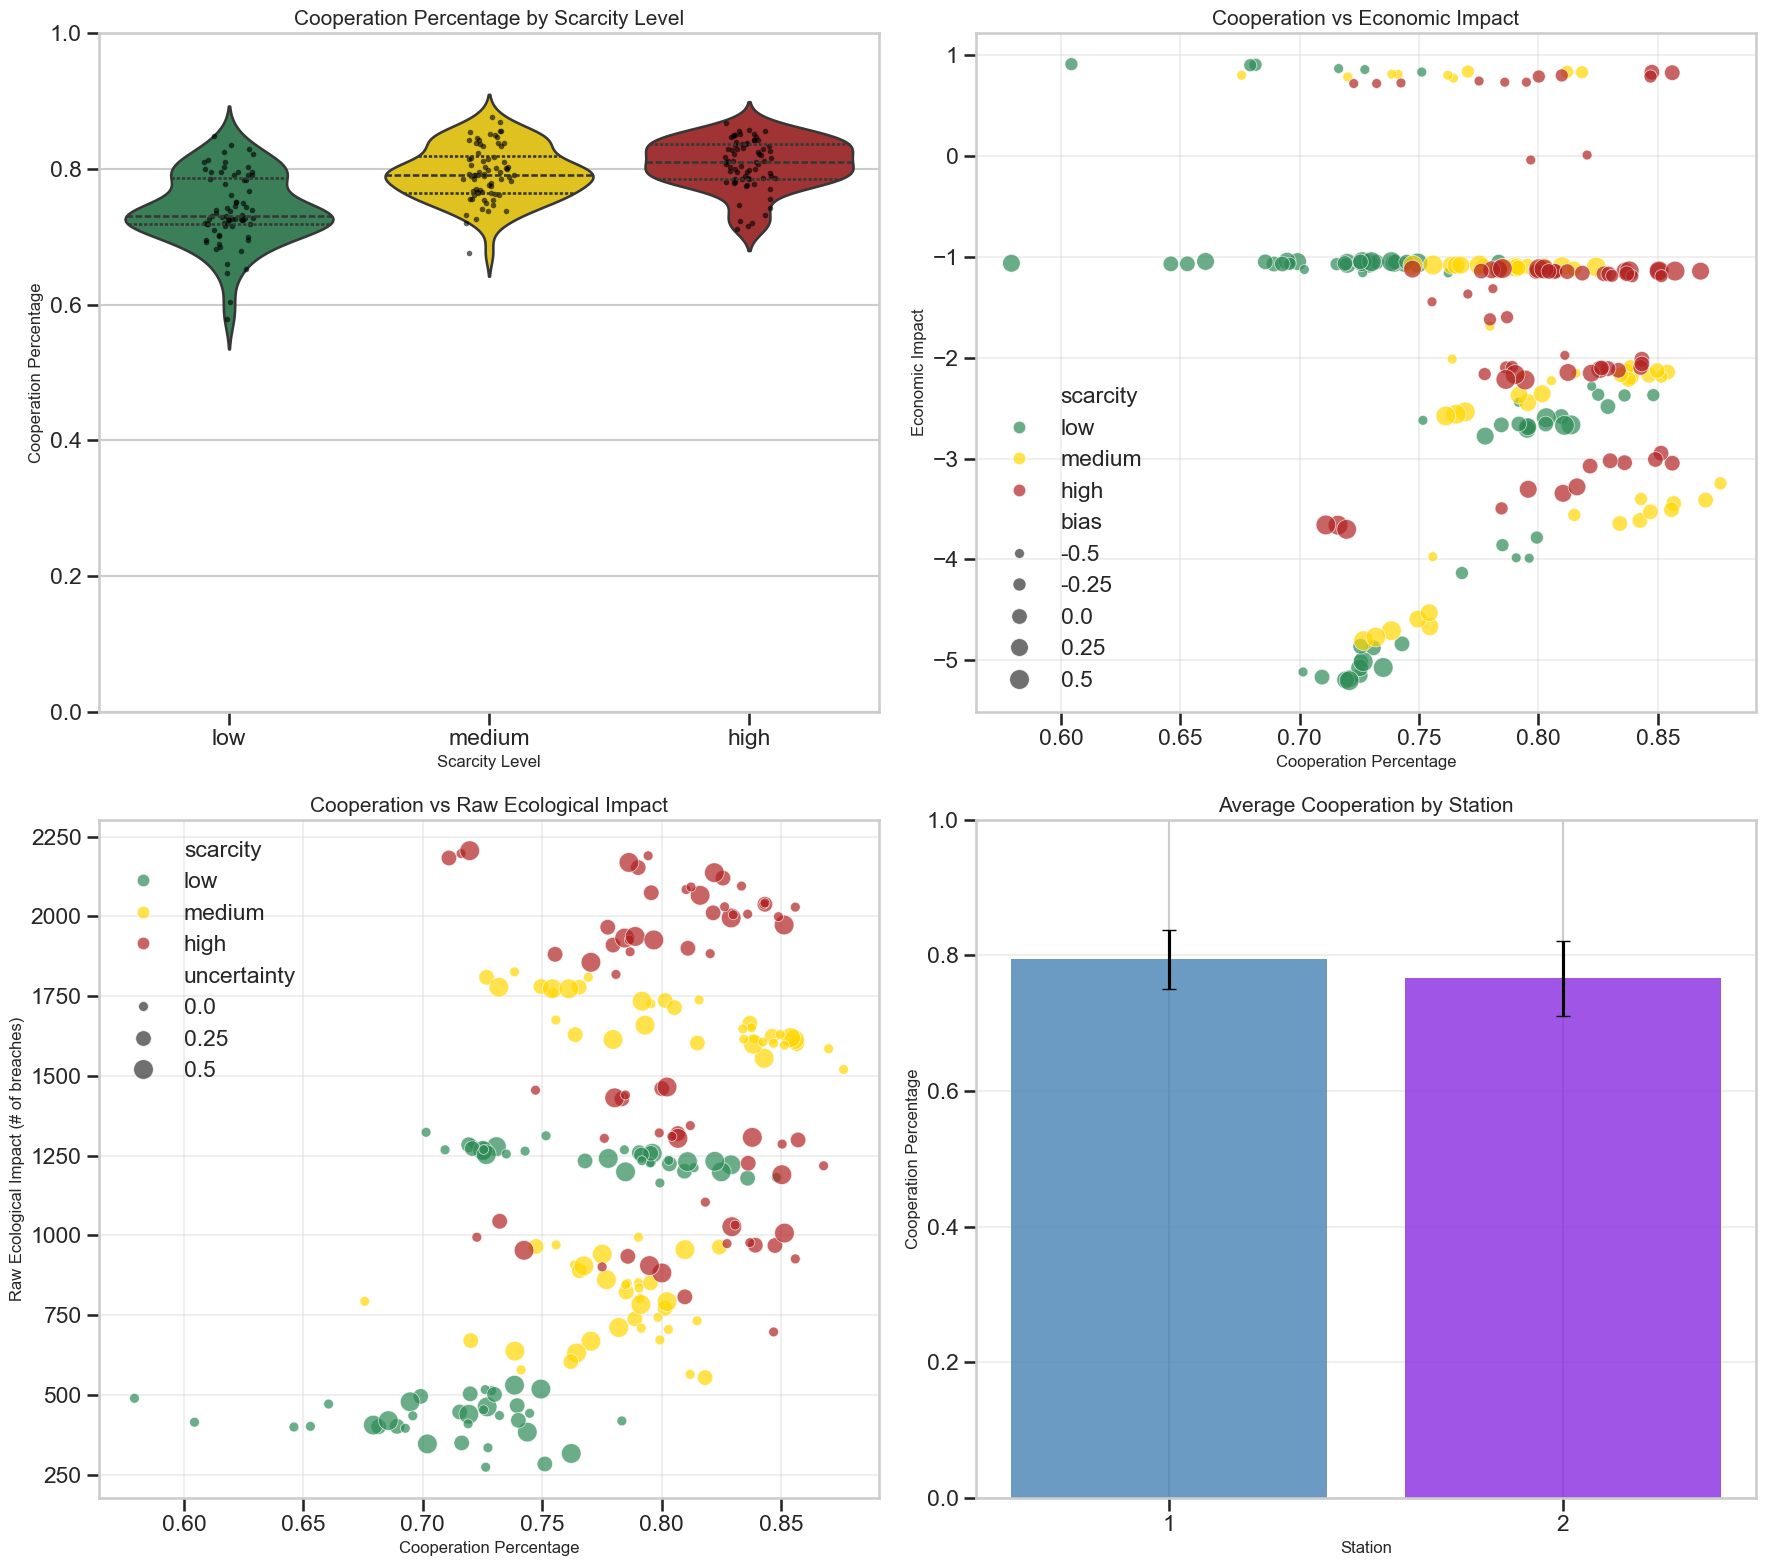

In [11]:
pma.analyze_cooperation_patterns(results_df)

## Raw Ecological Impact Analysis
Analyzing the raw (unscaled) ecological impact across different scenarios.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:1032: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:1066: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


1
2
{'1': '#4682B4', '2': '#8A2BE2'}


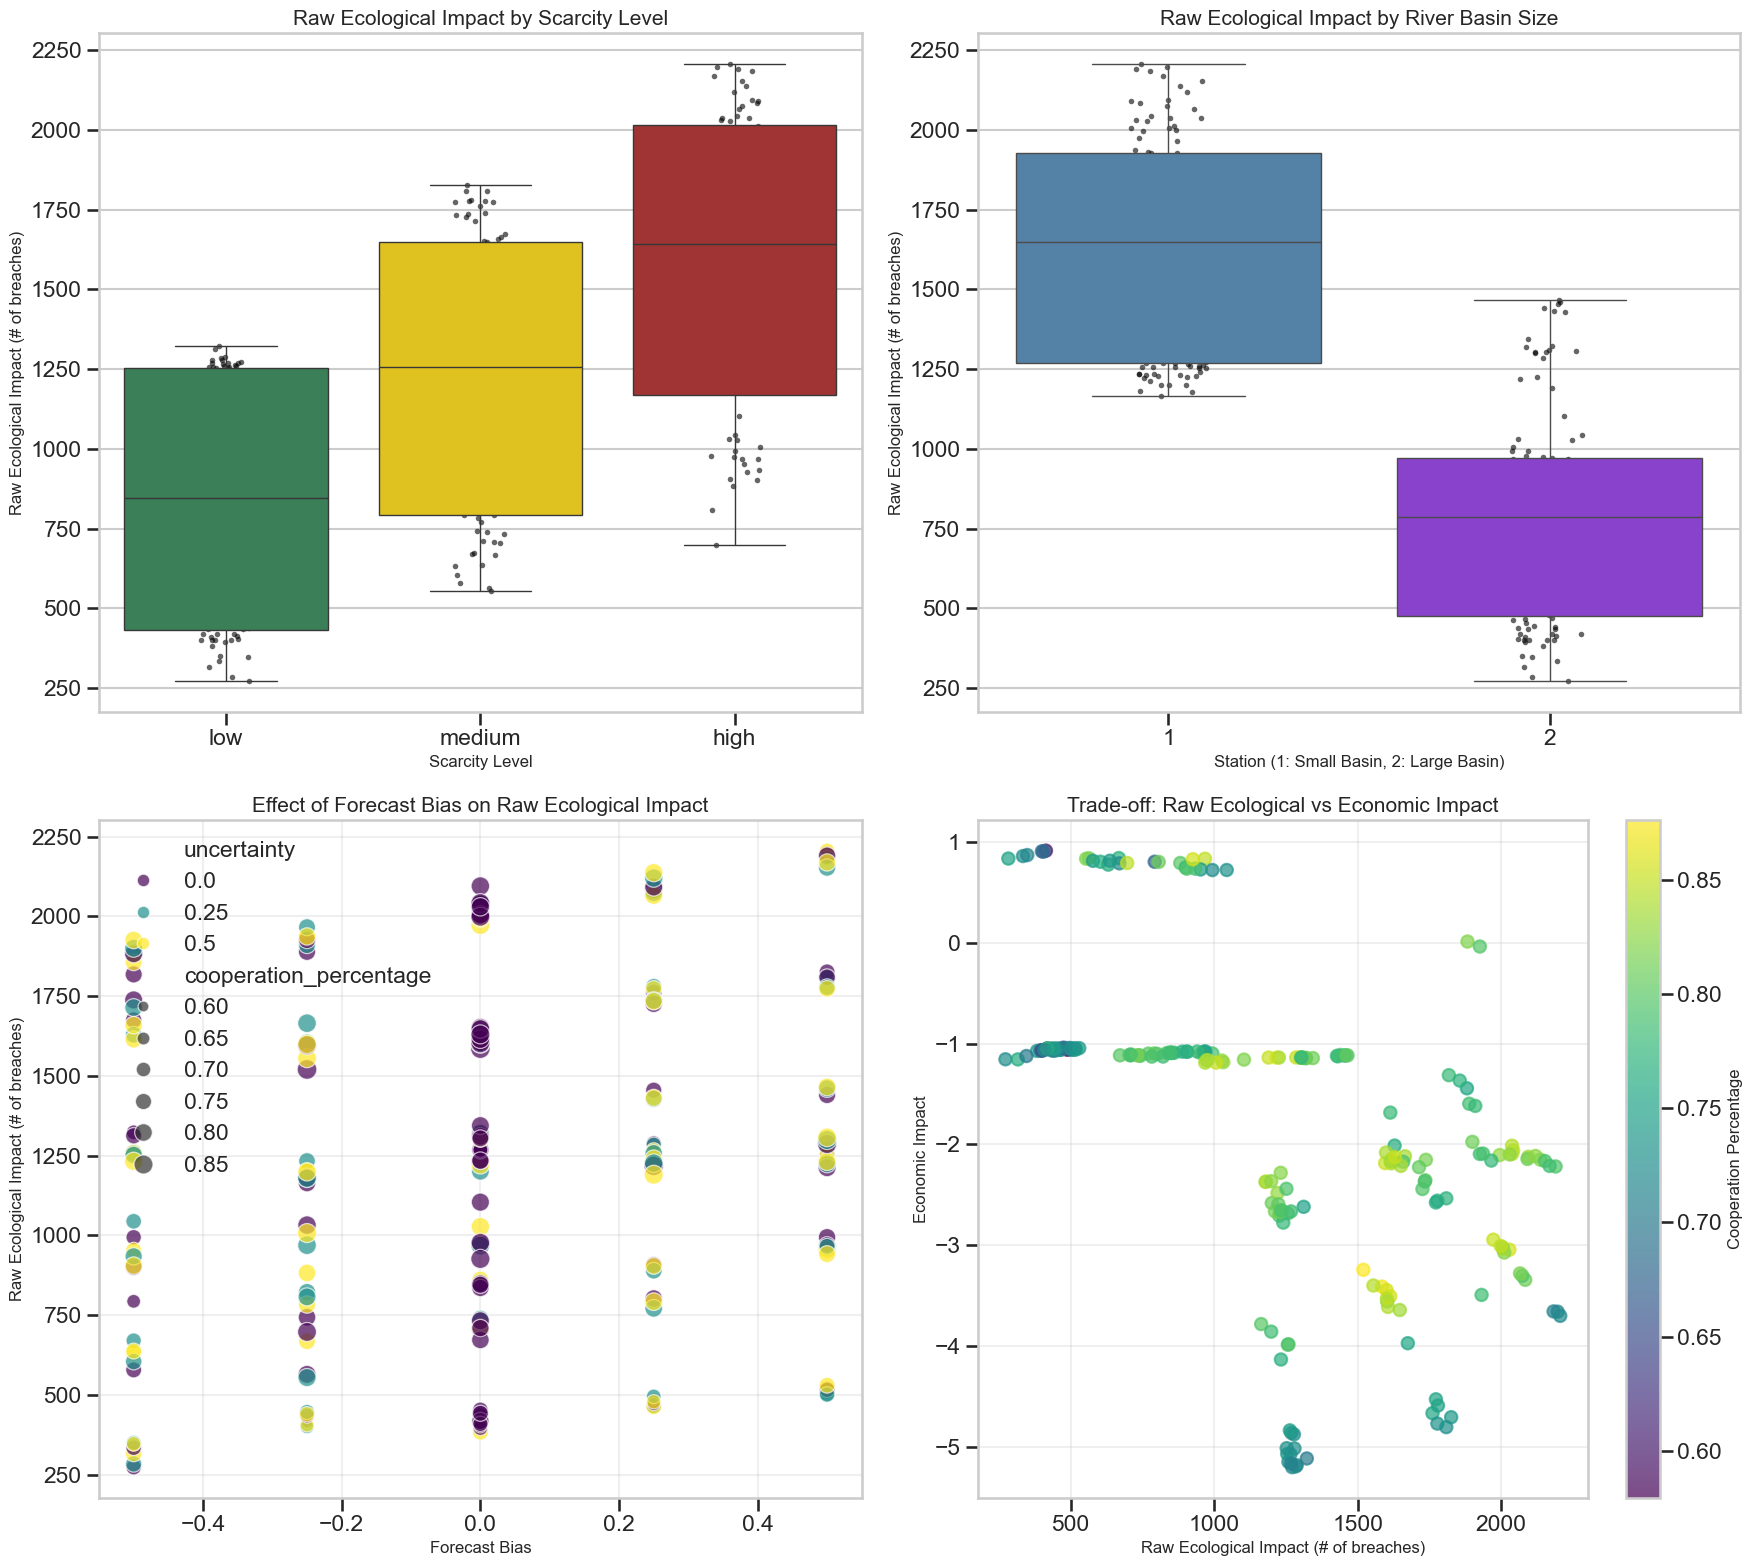

In [12]:
pma.analyze_raw_ecological_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


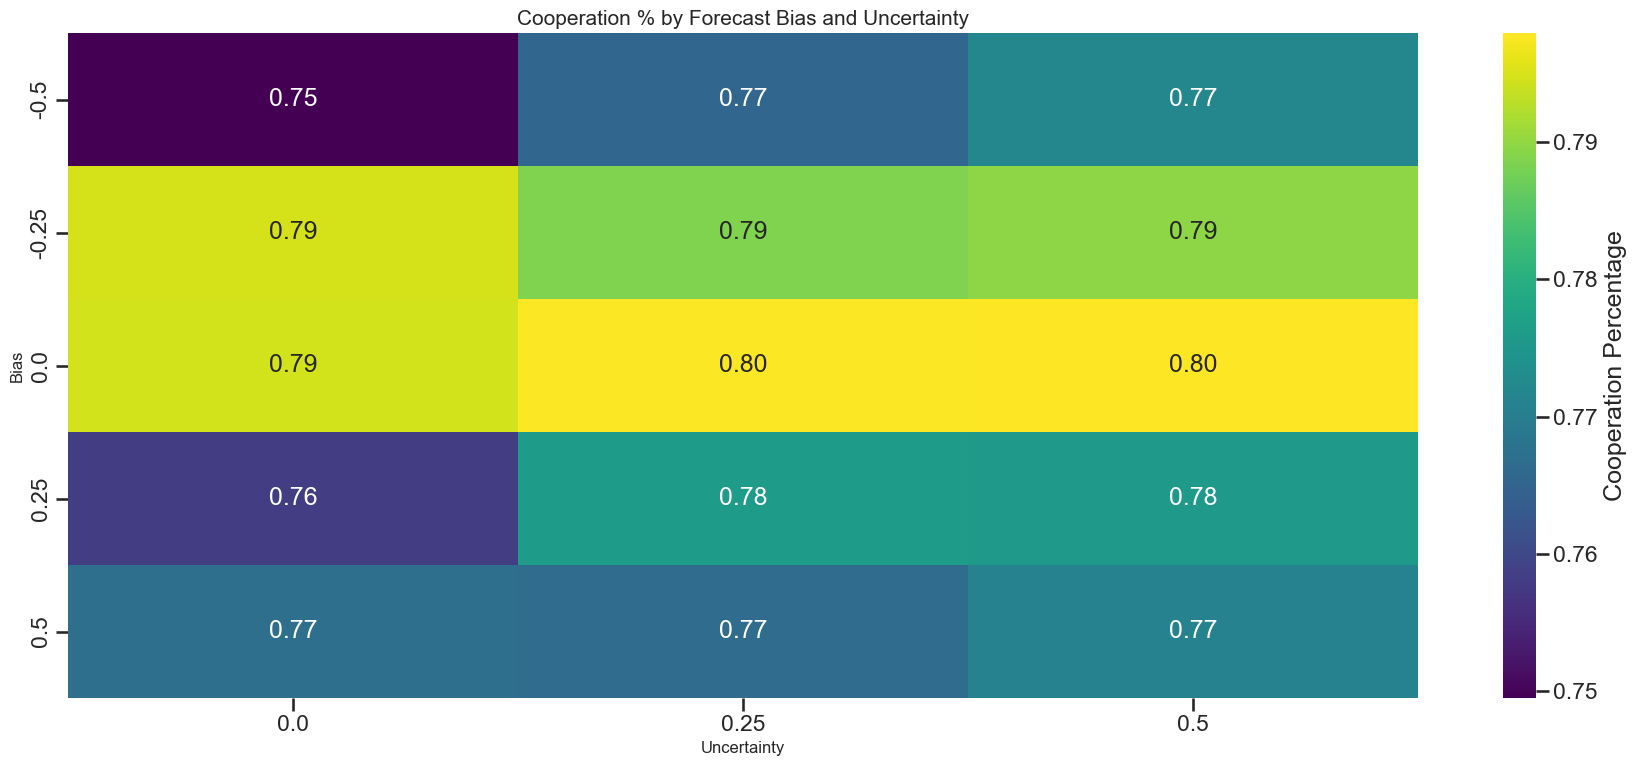

In [13]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.78
Average Raw Ecological Impact: 1216.0 breaches
Average Scaled Ecological Impact: 2.337
Average Economic Impact: -1.818

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.47   
raw_ecological_impact                     0.47                   1.00   
ecological_impact                         0.11                   0.21   
economic_impact                          -0.07                  -0.56   
bias                                     -0.02                   0.15   
uncertainty                              -0.00                   0.00   

                        ecological_impact  economic_impact  bias  uncertainty  
cooperation_percentage               0.11            -0.07 -0.02        -0.00  
raw_ecological_impact                0.21            -0.56  0.15         0.00  
ecological_impact                    

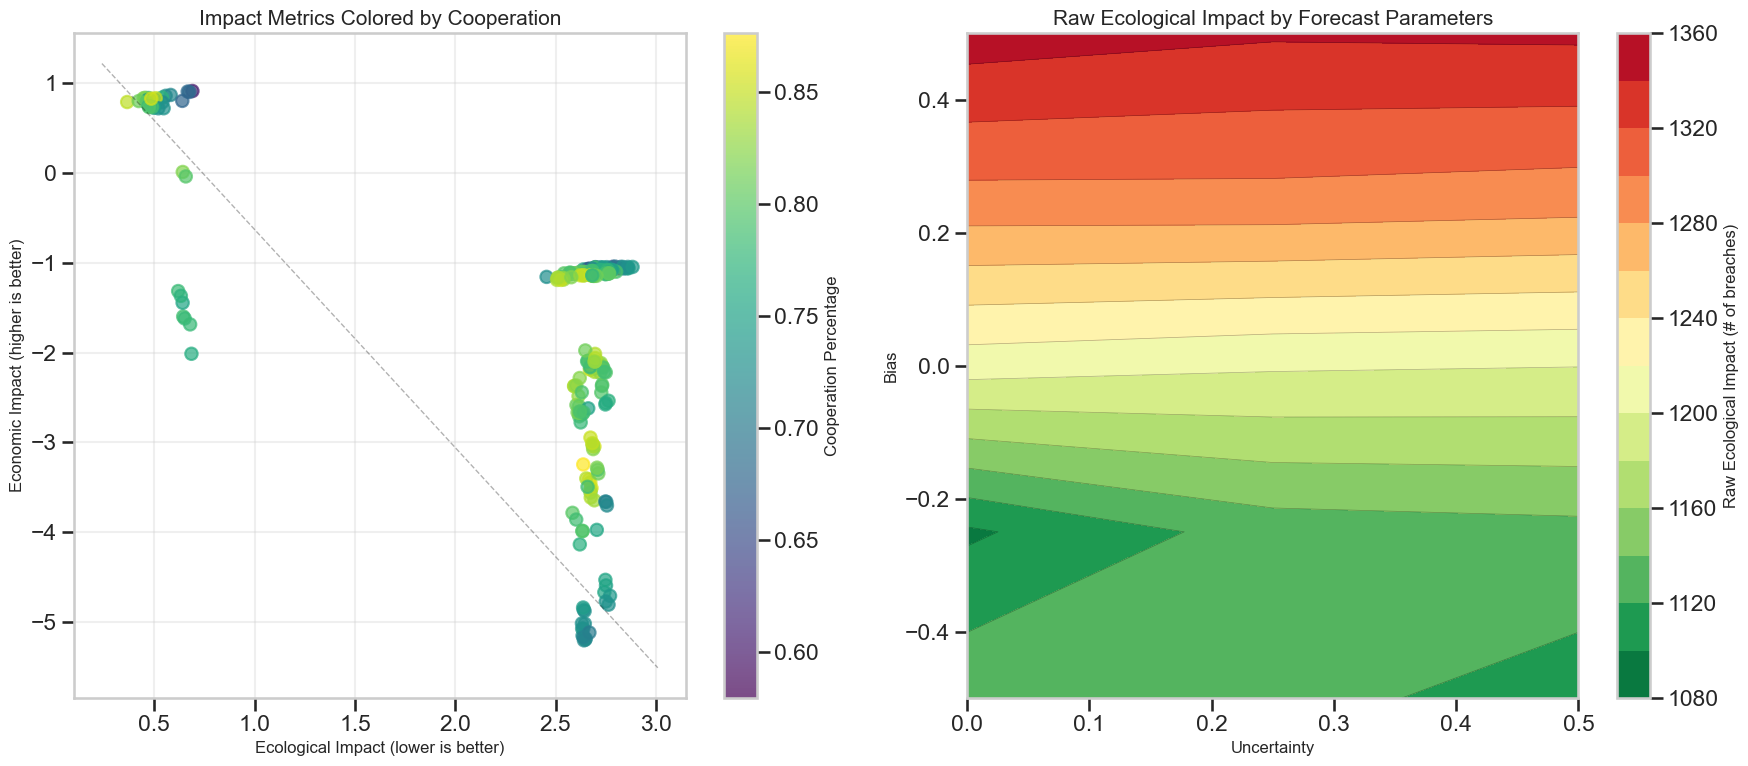

In [14]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!